Daniel Ross
September, 2022

In [2]:
import pandas as pd
import numpy as np
import random

import igraph as ig

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from PIL import Image as img

# Maze

## *Square*

#### maze side length 

In [17]:
dim=5

#### visual attributes 

In [25]:
default_colors = {"wall" : "forestgreen",
          "start" : "mediumpurple",
          "goal" : "mediumpurple",
          "path" : "mediumpurple",
          "solution" : "blueviolet"}

default_widths = {"wall" : 4,
          "path" : 1,
          "solution" : 3}

default_lw=10

colors = default_colors
widths = default_widths
lw = default_lw

#### file suffixes 

In [26]:
suffix = ""

#### grid graph with random edge weights

In [18]:
g = ig.Graph.Lattice([dim,dim], circular=False)

# Random edge weights
g.es["weight"] = [random.randint(1, 77) for _ in g.es]

# Add Row-Col ID attributes
for i in range(len(g.vs)):
    g.vs[i]["id"] = i
    #g.vs[i]["label"] = str(i)
    g.vs[i]["rowid"] = i // dim
    g.vs[i]["colid"] = i % dim

#### minimum spanning tree of grid graph

In [40]:
mst = g.spanning_tree(weights=g.es["weight"], return_tree=False)

# Get vertice IDs of mst edges
mst_edges = []

for edge in g.es[mst]:
    mst_edges.append([edge.source, edge.target])

#### graph of mst edges 

In [41]:
sp = ig.Graph(dim**2, edges=mst_edges)

#### shortest path solution 

In [42]:
shortest_path = sp.get_shortest_paths(0,dim**2-1, output="epath")

#### plot path 

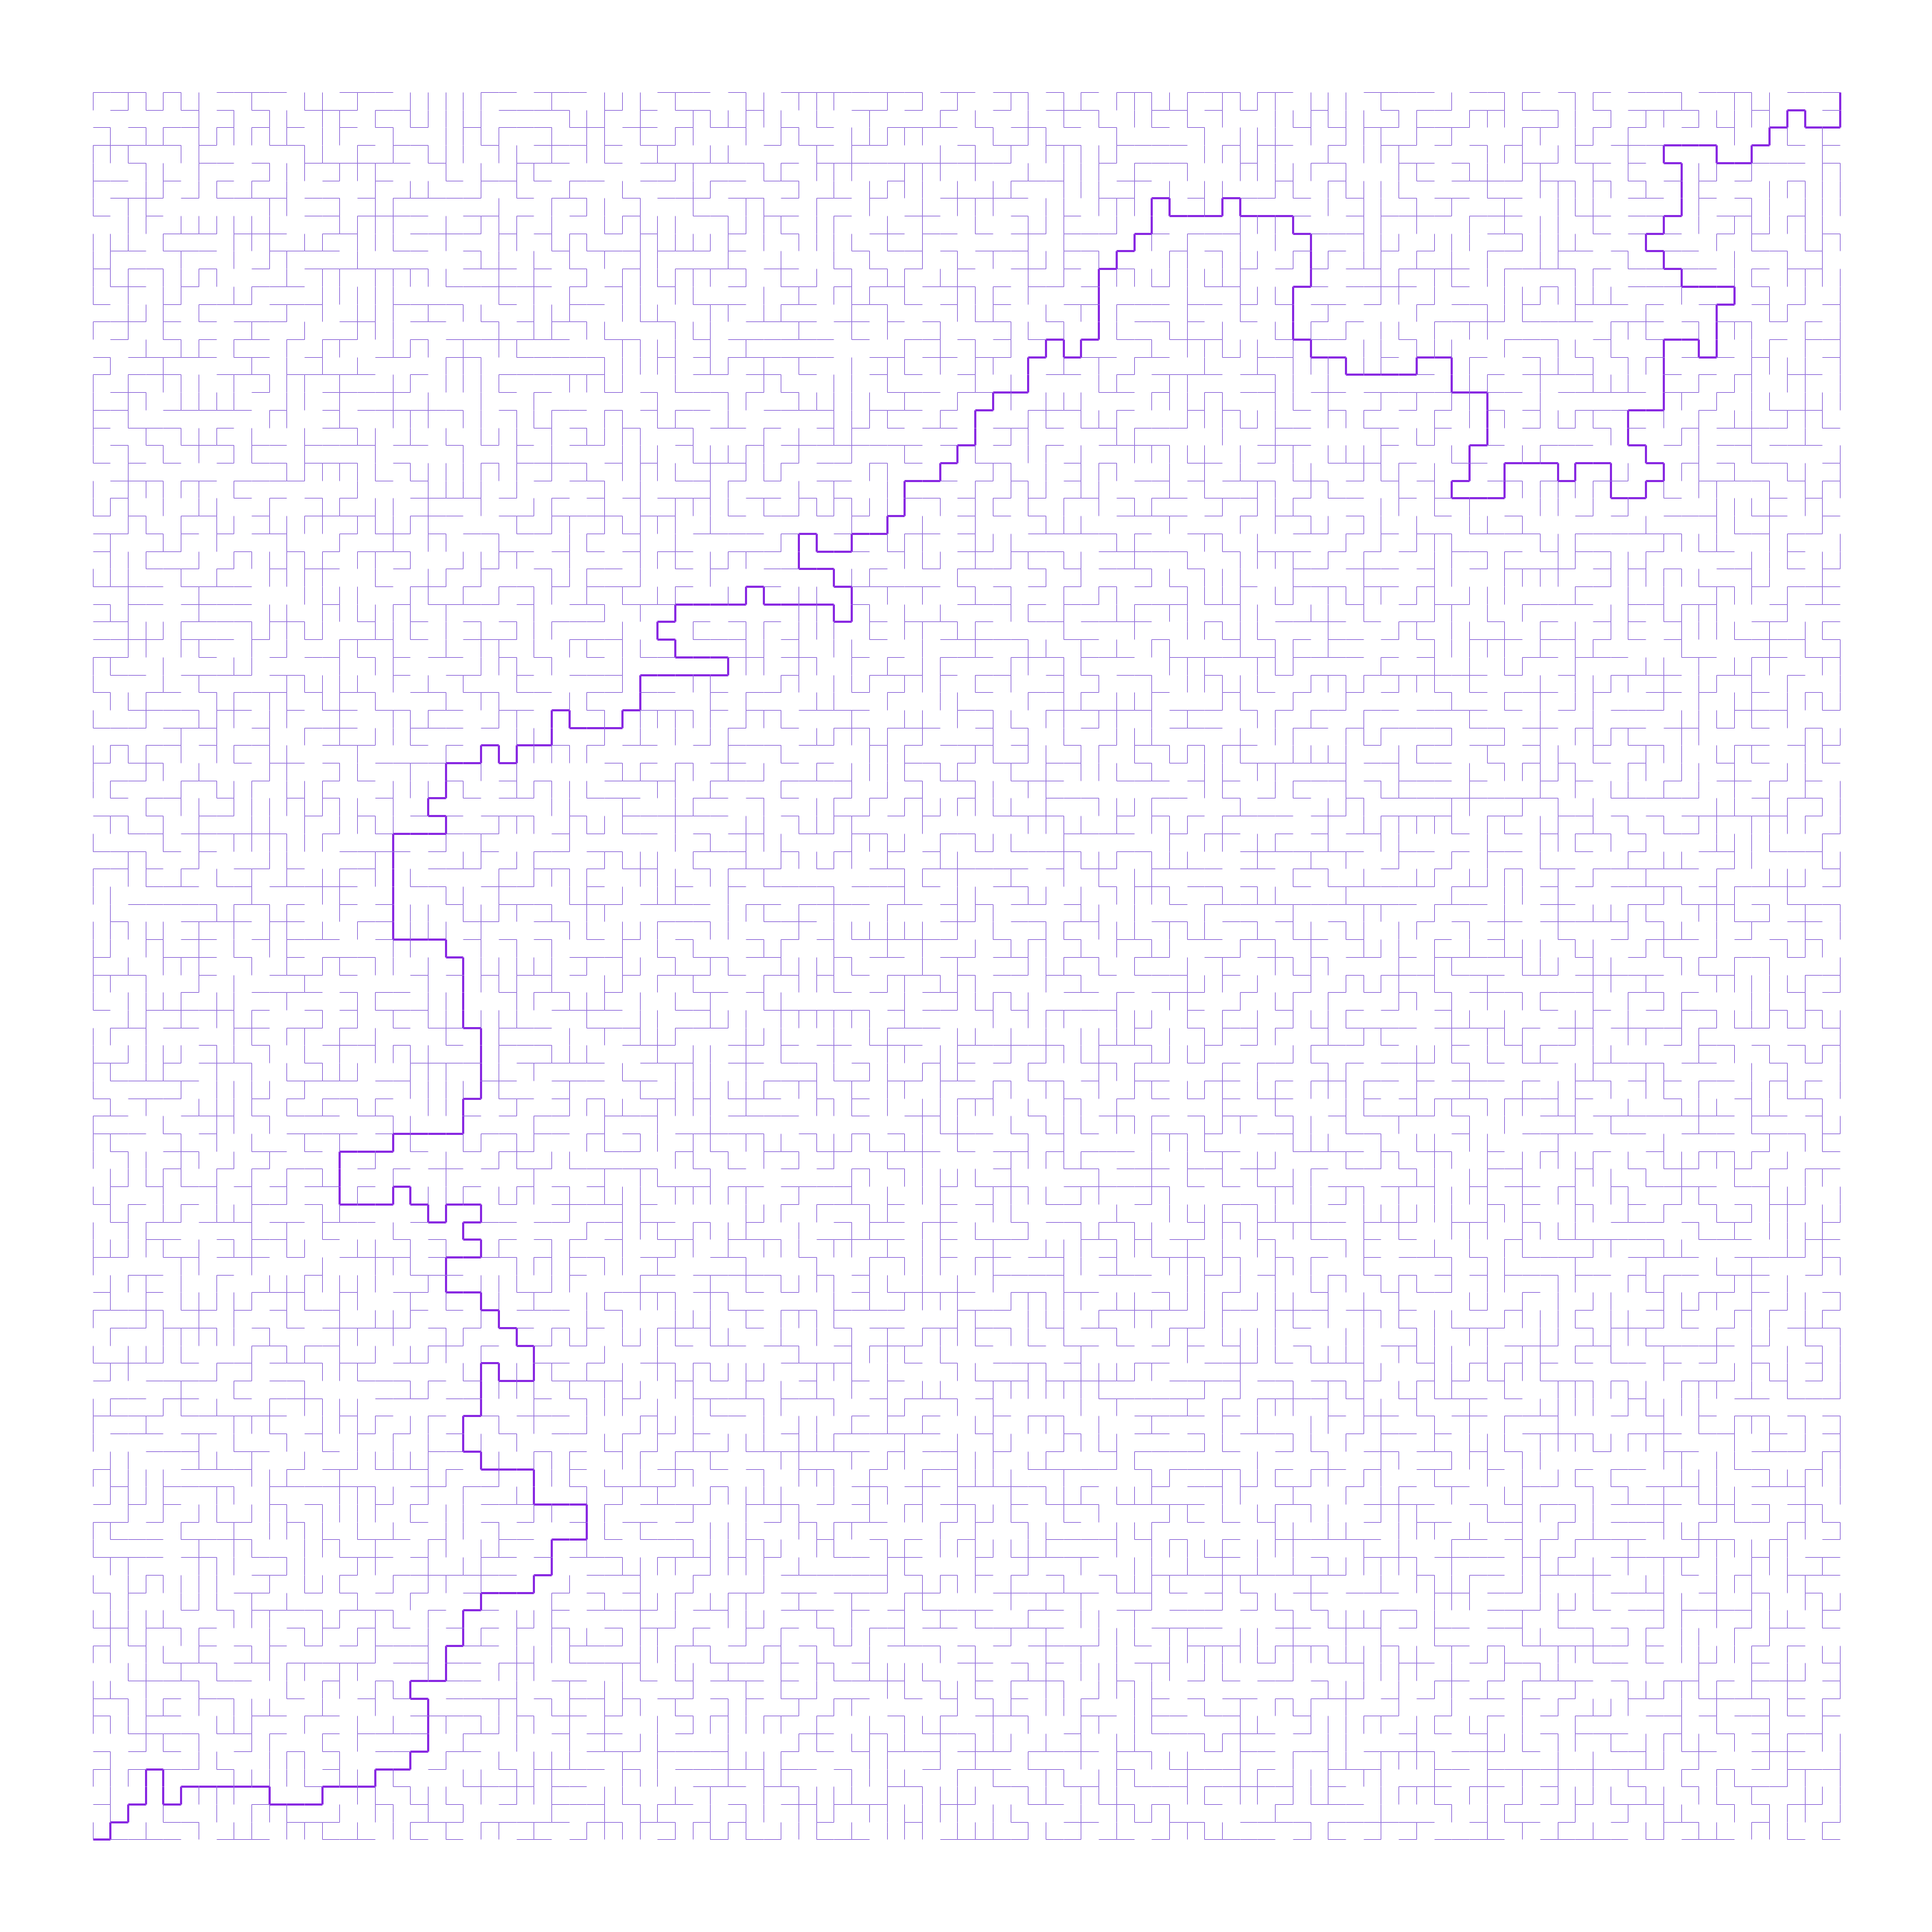

In [43]:
# Layout graph on grid
layout = sp.layout("grid")


# Set visual attributes
sp.es["color"] = colors["path"]
sp.es[shortest_path[0]]["color"] = colors["solution"]
sp.es["width"] = widths["path"]
sp.es[shortest_path[0]]["width"] = widths["solution"] 

# Set path image size proportional to walls dimension  
r = dim / (dim+1)

fig, ax = plt.subplots(figsize=(lw*r,lw*r))
ig.plot(
    sp,
    target=ax,
    layout=layout,
    vertex_size=0,
    edge_width=sp.es["width"],
    margin=0
)

#plt.figure(figsize=(100,100), dpi=100)
#plt.show()
plt.savefig(("Mazes/path" + str(dim) + ".png"), dpi=600, transparent=True)

#### grid graph neighbors DataFrame


In [44]:
neighbors = []
t=[]

sources_id = []
targets_id = []
sources_rowid = []
sources_colid = []

targets_rowid = []
targets_colid = []


for i in range(len(g.vs)):
    n=g.neighbors(i)
    for j in n:
        t=(i,j)
        t=tuple(sorted(t))
        neighbors.append(t)
        
        sources_id.append(t[0])
        targets_id.append(t[1])
        
        sources_rowid.append(g.vs[t[0]]["rowid"])
        sources_colid.append(g.vs[t[0]]["colid"])
    
        targets_rowid.append(g.vs[t[1]]["rowid"])
        targets_colid.append(g.vs[t[1]]["colid"])

neighbors = pd.DataFrame({"neighbors" : neighbors, 
                          "source_id" : sources_id,
                          "target_id" : targets_id,
                          "source_rowid" : sources_rowid, "source_colid" : sources_colid,
                          "target_rowid" : targets_rowid, "target_colid" : targets_colid})

neighbors = neighbors.drop_duplicates().reset_index(drop=True)

neighbors["rowdiff"] = neighbors["source_rowid"] != neighbors["target_rowid"]
neighbors["coldiff"] = neighbors["source_colid"] != neighbors["target_colid"]

#### path (mst connected vertices) DataFrame

In [45]:
source_target = []

sources_rowid = []
sources_colid = []

targets_rowid = []
targets_colid = []

for i in range(len(g.es[mst])):
    
    s=g.vs[g.es[mst][i].source]["id"]
    t=g.vs[g.es[mst][i].target]["id"]
        
    st=(s,t)    
    source_target.append(tuple(sorted(st)))

    sources_rowid.append(g.vs[g.es[mst][i].source]["rowid"])
    sources_colid.append(g.vs[g.es[mst][i].source]["colid"])
    
    targets_rowid.append(g.vs[g.es[mst][i].target]["rowid"])
    targets_colid.append(g.vs[g.es[mst][i].target]["colid"])

edges = pd.DataFrame({"source_target" : source_target,
                      "sources_rowid" : sources_rowid, "sources_colid" : sources_colid,
                      "targets_rowid" : targets_rowid, "targets_colid" : targets_colid})

# List of vertex index tuples with an mst edge
edge_vertices = list(edges["source_target"])

#### walls DataFrame 

In [46]:
# walls = neighbors - path
walls = neighbors[~neighbors["neighbors"].isin(edge_vertices)].reset_index(drop=True)

walls["wall_source_rowid"] = walls["source_rowid"]
walls["wall_source_colid"] = walls["source_colid"]

walls["wall_target_rowid"] = walls["target_rowid"]
walls["wall_target_colid"] = walls["target_colid"]

# Row difference 
walls.loc[walls["rowdiff"]==True, "wall_source_rowid"] = walls["wall_source_rowid"] + 1
walls.loc[walls["rowdiff"]==True, "wall_target_colid"] = walls["wall_target_colid"] + 1

# Column Difference
walls.loc[walls["coldiff"]==True, "wall_source_colid"] = walls["wall_source_colid"] + 1
walls.loc[walls["coldiff"]==True, "wall_target_rowid"] = walls["wall_target_rowid"] + 1

# Convert (Row, Column) ID to Vertex Index
walls["wall_source_id"] = walls["wall_source_rowid"]*(dim+1) + walls["wall_source_colid"]
walls["wall_target_id"] = walls["wall_target_rowid"]*(dim+1) + walls["wall_target_colid"]

# walls vertix index tuple
walls["walls"] = list(zip(walls["wall_source_id"], walls["wall_target_id"]))

#### boundary DataFrame and vertex index list  

In [47]:
sides_colid = np.repeat([0,dim],dim)

sides_source_rowid = pd.Series(range(0,dim))
sides_source_rowid = pd.concat([sides_source_rowid]*2)

sides_target_rowid = pd.Series(range(1,dim+1))
sides_target_rowid = pd.concat([sides_target_rowid]*2)

floors_rowid =  np.repeat([0,dim],dim)

floors_source_colid= pd.Series(range(0,dim))
floors_source_colid = pd.concat([floors_source_colid]*2)

floors_target_colid = pd.Series(range(1,dim+1))
floors_target_colid = pd.concat([floors_target_colid]*2)

sides = pd.DataFrame({"source_colid" : sides_colid,
                      "target_colid" : sides_colid,
                      "source_rowid" : sides_source_rowid,
                      "target_rowid" : sides_target_rowid}
                    )

floors = pd.DataFrame({"source_colid" : floors_source_colid,
                      "target_colid" : floors_target_colid,
                      "source_rowid" : floors_rowid,
                      "target_rowid" : floors_rowid}
                    )

boundaries = pd.concat([sides, floors], ignore_index=True, axis=0)

# Convert boundary (Row, Column) ID to vertex index
boundaries["source_id"] = boundaries["source_rowid"]*(dim+1) + boundaries["source_colid"]
boundaries["target_id"] = boundaries["target_rowid"]*(dim+1) + boundaries["target_colid"]

# boundary vertex index tuple
boundaries["boundaries"] = list(zip(boundaries["source_id"], boundaries["target_id"]))

# list of boundary vertex index tuples
walls_boundaries = list(walls.walls) + list(boundaries.boundaries)

#### walls graph 

In [48]:
w = ig.Graph(n=(dim+1)**2, edges=walls_boundaries)

for i in range(len(w.vs)):
    w.vs[i]["id"] = i
   # w.vs[i]["label"] = str(i)
    w.vs[i]["rowid"] = i // (dim+1)
    w.vs[i]["colid"] = i % (dim+1)

#### walls plot 

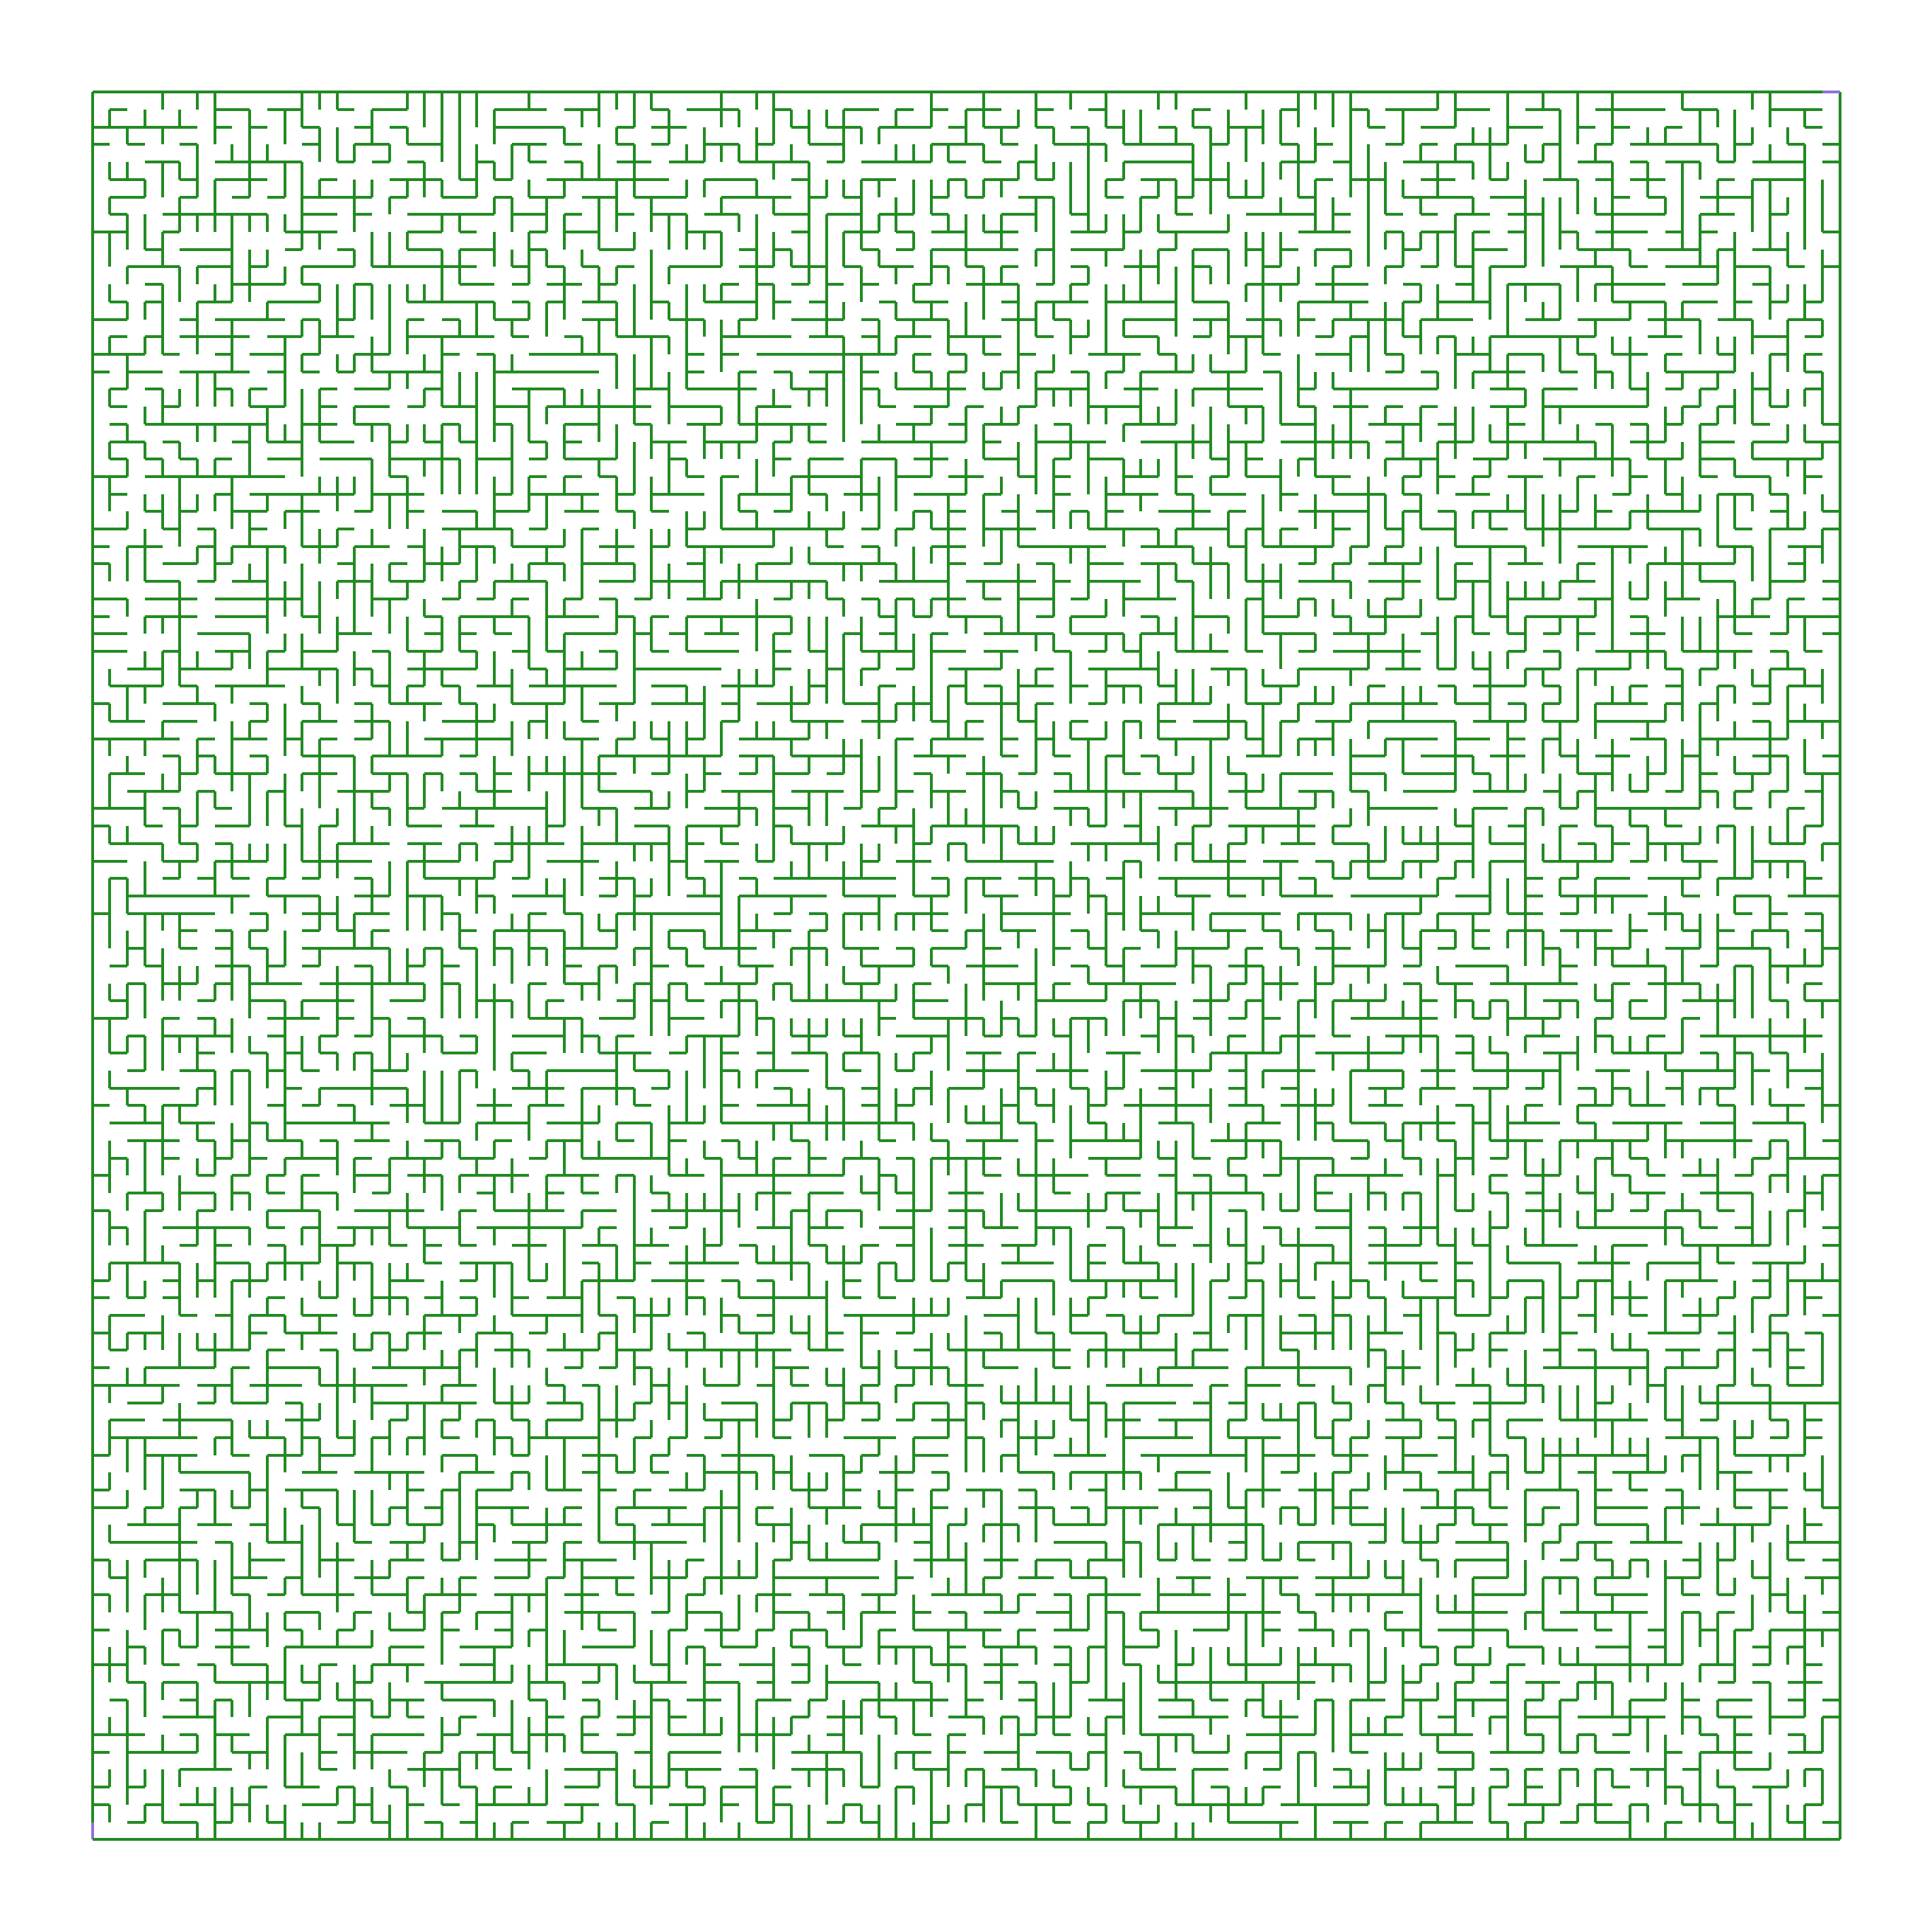

In [50]:
# layout
layoutwalls = w.layout("grid")

# visual attributes
## edge width
w.es["width"] = widths["wall"]
## edge colors
w.es["color"] = colors["wall"]
## start and goal edge colors
w.es[w.get_eid(w.vs[0], w.vs[dim+1])]["color"] = colors["start"]
w.es[w.get_eid(w.vs[(dim+1)**2 - 2], w.vs[(dim+1)**2 - 1])]["color"] = colors["goal"]


fig, ax = plt.subplots(figsize=(lw,lw))
ig.plot(
    w,
    target=ax,
    layout=layoutwalls,
    vertex_size=0,
    edge_width=w.es["width"],
    margin=0
)

plt.savefig(("Mazes/walls" + str(dim) + ".png"), dpi=600)

#### maze image overlay path on walls 

In [51]:
# set max pixel limit
img.MAX_IMAGE_PIXELS = 933120000

# open walls image
walls_img = img.open(("Mazes/walls" + str(dim) + suffix + ".png"))

# open path image
path_img = img.open(("Mazes/path" + str(dim) + suffix + ".png"))

# paste path on walls
## shift path pixels
ps = 150
walls_img.paste(path_img, (ps,ps), path_img)

# save maze to png
walls_img.save("Mazes/" + "maze" + str(dim) + suffix + ".png")

#### maze pdf
maze = img.open(("Mazes/" + "maze" + str(dim) + suffix + ".png"))
maze.load() # required for png.split()
mazergb = img.new("RGB", maze.size, (255, 255, 255))
mazergb.paste(maze, mask=maze.split()[3]) # 3 is the alpha channel

walls = img.open(("Mazes/walls" + str(dim) + suffix + ".png"))
walls.load() # required for png.split()
wallsrgb = img.new("RGB", walls.size, (255, 255, 255))
wallsrgb.paste(walls, mask=walls.split()[3]) # 3 is the alpha channel

images = [wallsrgb, mazergb]
path = "Mazes/" + "maze" + str(dim) + suffix + ".pdf"
images[0].save(
    path, "PDF" ,resolution=100.0, save_all=True, append_images=images[1:]
)

print("--#--")

--#--
